<a href="https://colab.research.google.com/github/Maagnitude/coupon-recommend-models/blob/main/coupon_recommend_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Βασική Εργασία** στο μάθημα **Εξόρυξη Δεδομένων**

# **Τμήμα Πληροφορικής και Τηλεματικής - Χαροκόπειο Πανεπιστήμιο**

## **Χαρίτος Δημήτριος -------------------- it21395**
## **Καζάζης Γεώργιος --------------------- it214124**
## **Ζαρρή Σωτηρία Νικολίτσα ------------ it219141**

Στην παρούσα εργασία θα αναπτύξουμε **μοντέλα κατηγοριοποίησης**, για να εξετάσουμε το πρόβλημα του συστήματος **κουπονιών**. Δηλαδή το σε ποιους πιθανούς πελάτες, πρέπει να προσφέρουμε κάποιο κουπόνι, το οποίο πάντα ήταν ένα μεγάλο πρόβλημα, και με τεχνικές **Μηχανικής Μάθησης** θα προσπαθήσουμε να δημιουργήσουμε ένα καλύτερο σύστημα συστάσεων κουπονιών.

Ύστερα θα αναπτύξουμε **μοντέλα συσταδοποίησης**, για να εξετάσουμε και την πλευρά των μοντέλων χωρίς επίβλεψη (**unsupervised**), στην αντιμετώπιση του παρόντος προβλήματος.

**Αρχίζοντας...**

# **Βιβλιοθήκες**
Κάνουμε import τα απαραίτητα **modules**. 
*   Την **pandas** και την **numpy** για την διαχείριση των δεδομένων μας.

*  Την **matplotlib.pyplot** και την **seaborn** για την οπτικοποίηση των δεδομένων μας. **Ιστογράμματα**, **heatmaps** κλπ.

*  Την **missingno** ώστε να οπτικοποιήσουμε το αν υπάρχουν ελλιπείς εγγραφές.

*   Από την **sklearn** κάνουμε import:
      *   Την **linear_model** για να εκπαιδεύσουμε το **Logistic Regression model**.
      *   Την **model_selection** για την εισαγωγή του **train_test_split** για το χώρισμα του train και του test sets.
      *  Από το **neighbors**, βάζω το **KNeighborsClassifier** για την ανάπτυξη ενός kNN μοντέλου.
      *  Από το **metrics**, βάζω το **accuracy_score**.
      *  Την **RandomForestClassifier** για να εκπαιδεύσουμε ένα Random Forest model.
*  Το **tensorflow**, και από αυτό, τα **keras** και **layers** για την ανάπτυξη νευρωνικών δικτύων.

*  Τέλος, κάνουμε import τα **warnings** και τα φιλτράρουμε, ώστε να μην εμφανίζονται.

In [497]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings(action='ignore')

# **A) EDA - Preprocessing / Προετοιμασία**
Το **πρώτο μέρος** αφορά την **προετοιμασία** των δεδομένων, από την **φόρτωση** τους, μέχρι τον **καθαρισμό** τους (το **πέταμα** όσων δεν χρειάζονται, την **συμπλήρωση** των τιμών **null** κτλ.), και το **χώρισμα** τους σε **train-test sets**. Επίσης θα υπάρξουν επεξηγηματικά **plots**, όπου χρειάζεται.

## **Φόρτωση του dataset από το csv αρχείο**
Περνάμε το **url** του dataset στην μεταβλητή df με την χρήση της μεθόδου **read_csv**, και εκτυπώνουμε τις 5 πρώτες γραμμές για να δούμε ότι έγιναν όλα σωστά.

Το **url** είναι του **raw dataset** απ το repository μου στο **github**.

In [446]:
url = "https://raw.githubusercontent.com/Maagnitude/coupon_recommend_models/main/in-vehicle-coupon-recommendation.csv"
df = pd.read_csv(url)
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## **Άλλος τρόπος φόρτωσης (Drive mount)**

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/in-vehicle-coupon-recommendation.csv')

## **Σχήμα του Dataframe**. 

Έχουμε ένα **dataframe** σχήματος **12684 x 26**.

**12684 εγγραφές** (δείγματα) και **26 χαρακτηριστικά** (features)

In [447]:
df.shape

(12684, 26)

## **Ελλιπείς εγγραφές**
Με την χρήση του **df.info()**, παρατηρούμε ότι υπάρχουν **ελλιπείς εγγραφές**. Το χαρακτηριστικό **car** έχει μόνο **108 τιμές** που **δεν είναι null**, από τις **12684**. Το καλύτερο εδώ είναι να **πετάξουμε** αυτό το χαρακτηριστικό μιας και δεν μας προσφέρει κάτι. Ύστερα με την χρήση του **df.isnull().sum()**, θα δούμε ακριβώς πόσες τιμές είναι **null** σε κάθε χαρακτηριστικό. Επίσης οπτικοποιούμε τις ελλιπείς εγγραφές με την χρήση της βιβλιοθήκης **missingno**.

In [448]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [449]:
df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

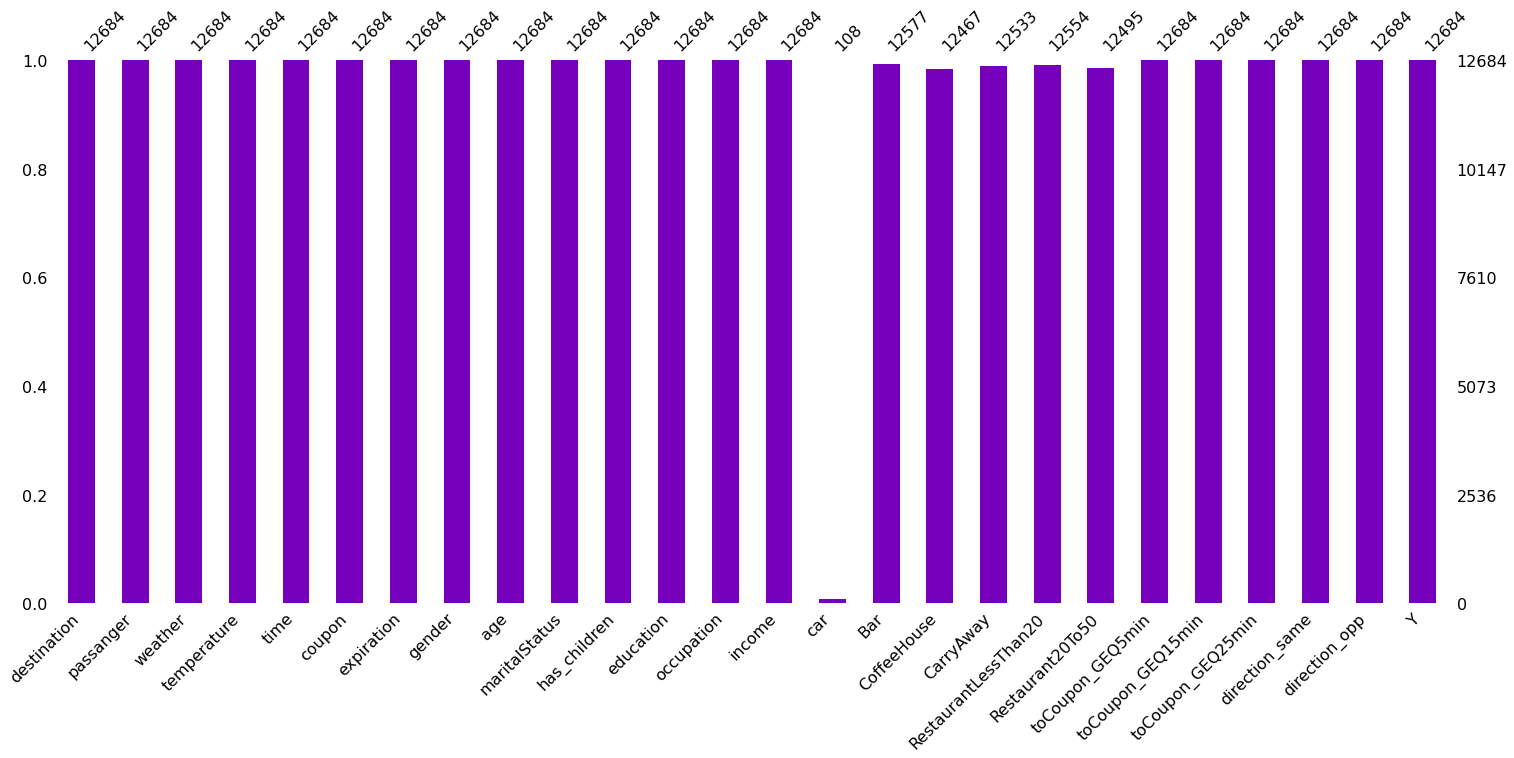

In [450]:
null_plot = msno.bar(df, color="#7600BC")

In [451]:
df= df.drop("car", axis='columns')

## **Imputing**
Εδώ ελέγχουμε τον αριθμό των τιμών για κάθε κατηγορική τιμή. Φαίνεται σαν μια καλή στρατηγική για κάθε τιμή null, να την γεμίζουμε με την τιμή που εμφανίστηκε **πιο συχνά** στις υπόλοιπες εγγραφές (**impute**). 

Ύστερα ελέγχουμε να δούμε ότι δεν υπάρχουν καθόλου null τιμές στις εγγραφές μας με την χρήση της **df.isnull().sum()**.

In [452]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['Bar'] = imputer.fit_transform(df['Bar'].values.reshape(-1,1))[:,0]

In [453]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['CoffeeHouse'] = imputer.fit_transform(df['CoffeeHouse'].values.reshape(-1,1))[:,0]

In [454]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['CarryAway'] = imputer.fit_transform(df['CarryAway'].values.reshape(-1,1))[:,0]

In [455]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['RestaurantLessThan20'] = imputer.fit_transform(df['RestaurantLessThan20'].values.reshape(-1,1))[:,0]

In [456]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['Restaurant20To50'] = imputer.fit_transform(df['Restaurant20To50'].values.reshape(-1,1))[:,0]

In [459]:
df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

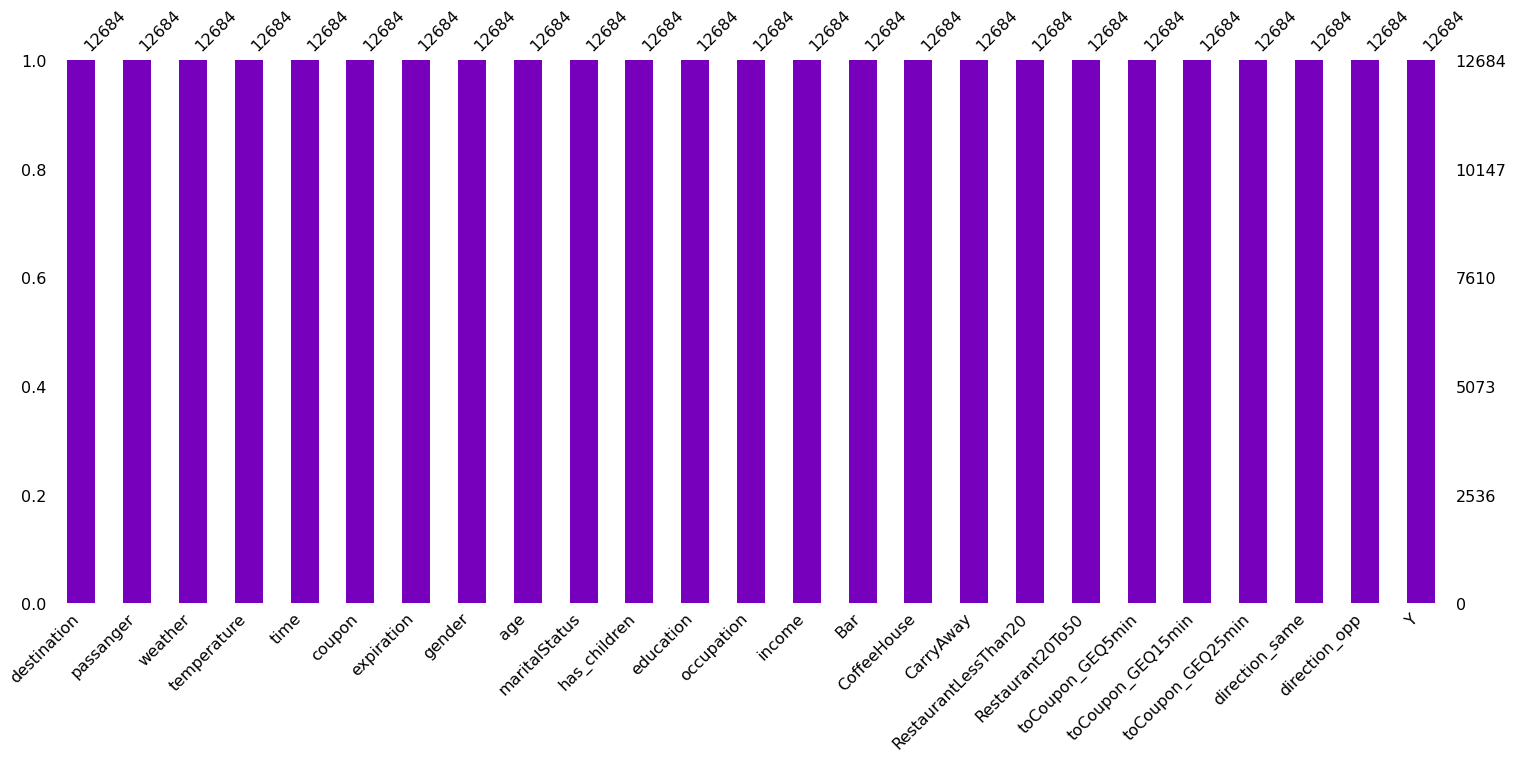

In [458]:
new_null_plot = msno.bar(df, color="#7600BC")

## **Μοναδικές τιμές**
Ελέγχουμε τις μοναδικές (**διαφορετικές**) τιμές που μπορούν να λάβουν τα ποσοτικά χαρακτηριστικά μας, με την χρήση της **nunique()**, και παρατηρούμε ότι το χαρακτηριστικό "**toCoupon_GEQ5min**" παίρνει μόνο μία τιμή, οπότε δεν το χρειαζόμαστε, και θα το πετάξουμε.

In [460]:
df.select_dtypes('int64').nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

In [461]:
df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

Επίσης τυπώνοντας τον αριθμό της κάθε τιμής που λαμβάνει το "**direction_opp**" και το "**direction_same**", παρατηρούμε ότι στον αριθμό εγγραφών που το ένα έχει **0**, το άλλο έχει **1**, και το αντίστροφο (όπως άλλωστε καταλαβαίνουμε και από την ονομασία του χαρακτηριστικού). Οπότε μας φτάνει να κρατήσουμε το ένα (**direction_same**), γιατί το άλλο είναι **άχρηστη πληροφορία**.

In [462]:
df['direction_same'].value_counts()

0    9960
1    2724
Name: direction_same, dtype: int64

In [463]:
df['direction_opp'].value_counts()

1    9960
0    2724
Name: direction_opp, dtype: int64

In [464]:
df.drop(columns=['direction_opp'], inplace=True)

## **Διπλότυπες Εγγραφές**
Ύστερα πετάμε τις **διπλότυπες εγγραφές** (**drop duplicates**) γιατί και δεν μας προσφέρουν κάτι, και μπορεί να **υπερεκπαιδευτούν** (**overfitting**) τα μοντέλα μας.

In [465]:
df.shape

(12684, 23)

In [466]:
df.drop_duplicates(inplace=True)
df.shape

(12610, 23)

## **Ιστόγραμμα**
Κάνουμε plot το ιστόγραμμα κάθε **ποσοτικού** χαρακτηριστικού ξεχωριστά (και του **label - Y**). Δεν μας βοηθάει ιδιαίτερα μιας και τα **5 από τα 6** ιστογράμματα έχουν ως τιμές τα **0 και 1**, οπότε δεν μπορεί να παρατηρηθεί κάποια ουσιαστική **κατανομή**. Μόνο το ότι το "toCoupon_GEQ25min" έχει πάνω από 10000 εγγραφές με την τιμή 0, και ότι στο "temperature" παρατηρείται **αρνητική ασυμμετρία** (περισσότερες εγγραφές να έχουν την τιμή **80**, λιγότερες την **55** και ακόμα πιο λίγες την **30**) 

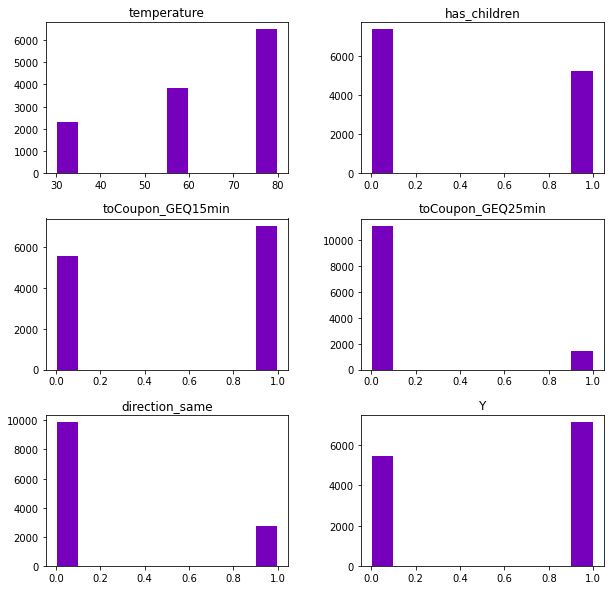

In [467]:
df_histplot = df.hist(grid=False, figsize=(10,10), color='#7600BC', zorder=2, rwidth=0.95)

## **Describe**
Παρακάτω εμφανίζουμε την στατιστική ανάλυση των ποσοτικών δεδομένων μας, με την χρήση της μεθόδου **describe()**. Πάλι δεν βγάζουμε κάποιο παραπάνω συμπέρασμα πέρα από αυτό που μπορούσαμε να δούμε και στο ιστόγραμμα σχετικά με το πόσες εγγραφές αντιστοιχούν σε κάθε τιμή χαρακτηριστικού.

Σημ: Με **Transpose (.T)** ο πίνακας είναι πιο ευκρινής.

In [468]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,12610.0,63.267248,19.153386,30.0,55.0,80.0,80.0,80.0
has_children,12610.0,0.414512,0.492657,0.0,0.0,0.0,1.0,1.0
toCoupon_GEQ15min,12610.0,0.559794,0.496432,0.0,0.0,1.0,1.0,1.0
toCoupon_GEQ25min,12610.0,0.116019,0.320260,0.0,0.0,0.0,0.0,1.0
direction_same,12610.0,0.215543,0.411215,0.0,0.0,0.0,0.0,1.0
Y,12610.0,0.567565,0.495434,0.0,0.0,1.0,1.0,1.0


## **Ετεροσυσχέτιση**
Με την χρήση της συνάρτησης **corr()** της βιβλιοθήκης **pandas**, ελέγχουμε την **ετεροσυσχέτιση** μεταξύ των χαρακτηριστικών. Συγκεκριμένα τυπώνουμε την συσχέτιση όλων των χαρακτηριστικών με το **label** μας - '**Y**', και παρακάτω θα οπτικοποιήσουμε τις συσχετίσεις όλων.

In [469]:
corr = df.corr()
corr['Y']

temperature          0.059393
has_children        -0.045056
toCoupon_GEQ15min   -0.082693
toCoupon_GEQ25min   -0.108139
direction_same       0.014932
Y                    1.000000
Name: Y, dtype: float64

## **Heatmap**
Εδώ οπτικοποιούμε την **ετεροσυσχέτιση** των χαρακτηριστικών. Αυτή η δισδιάστατη αναπαράσταση μας βοηθάει να καταλάβουμε πολύ πιο εύκολα την ετεροσυσχέτιση, μέσω των χρωμάτων, αλλά και των τιμών. Παρατηρούμε όπως και πιο πάνω, ότι μεγαλύτερη συσχέτιση με το **Y** έχει το **toCoupon_GEQ25min** και πιο συγκεκριμένα αρνητική συσχέτιση. (**-0.1**)

Σημ: Είχαμε δει και στο ιστόγραμμα ότι αυτό το χαρακτηριστικό έχει την **τιμή 0** σε **πάνω από 10000 εγγραφές**.

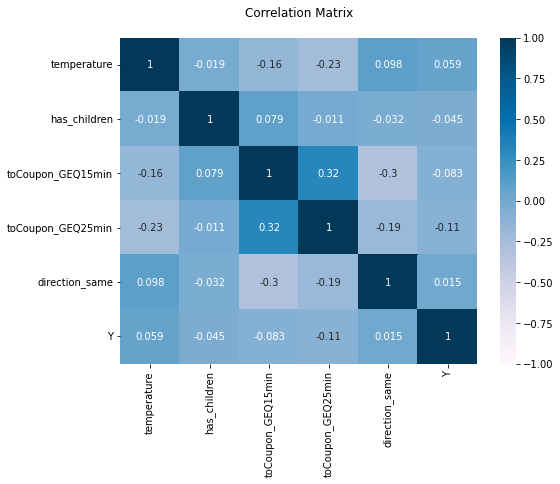

In [470]:
plt.figure(figsize=(8,6))
heat = sns.heatmap(corr, annot=True, vmin=-1.0, cmap='PuBu')
plt.title("Correlation Matrix\n")
plt.show()

## **ONE-HOT ENCODING**

Εν συνεχεία, θα μετατρέψουμε κάθε **κατηγορικό** χαρακτηριστικό σε "**αριθμητικό**" με την χρήση του **one-hot encoding**, δημιουργώντας τόσες στήλες όσες είναι οι διαφορετικές τιμές του χαρακτηριστικού, και δίνοντας του **1** στην στήλη της τιμής που είχε η κάθε εγγραφή, και **0** σε όλες τις υπόλοιπες. (αυτοματοποιημένη διαδικασία)

**object -> uint8**

In [471]:
df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
Y                        int64
dtype: object

Παίρνουμε όλα τα **κατηγορικά** (χωρίς τις ποσοτικά) και τα εισάγουμε στην μεταβλητή **df_categorical**. Ύστερα με την χρήση της **get_dummies** των **pandas**, εφαρμόζουμε το **one-hot encoding**. 

Μετά από αυτό τα χαρακτηριστικά μας, από **23**, έχουν γίνει **108** (δηλαδή 108 στήλες), και πλέον μπορούμε να εκπαιδεύσουμε τα μοντέλα μας πάνω σε αυτά.

In [472]:
df_categorical = df.select_dtypes(exclude='number')

In [473]:
df_categorical.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
0,No Urgent Place,Alone,Sunny,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
1,No Urgent Place,Friend(s),Sunny,10AM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
2,No Urgent Place,Friend(s),Sunny,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
3,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
4,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3


In [474]:
for value in df_categorical:
  df = pd.get_dummies(df, columns=[value])

In [475]:
df.dtypes

temperature               int64
has_children              int64
toCoupon_GEQ15min         int64
toCoupon_GEQ25min         int64
direction_same            int64
                          ...  
Restaurant20To50_1~3      uint8
Restaurant20To50_4~8      uint8
Restaurant20To50_gt8      uint8
Restaurant20To50_less1    uint8
Restaurant20To50_never    uint8
Length: 108, dtype: object

## **Clustering Dataframe**
Τώρα που το **dataset** μας είναι έτοιμο προς χρήση για **εκπαίδευση**, θα πάρουμε ένα **αντίγραφο** του για να το χρησιμοποιήσουμε στο **Clustering** αργότερα.

In [476]:
cluster_df = df.copy()

## **Second Dataframe**
Επίσης θα πάρουμε κι άλλο ένα **αντίγραφο**, για να το χρησιμοποιήσουμε για το **δεύτερο ερώτημα** που αφορά την εκπαίδευση μοντέλου σε ένα υποσύνολο **5 γνωρισμάτων**.

In [477]:
sec_df = df.copy()

# **Β) Classification / Κατηγοριοποίηση** 
Στο **δεύτερο μέρος** ακολουθούν οι **εκπαιδεύσεις** και οι **προβλέψεις 6 μοντέλων κατηγοριοποίησης**
* **Logistic Regression**
* **KNN Algorithm**
* **SVM Algorithm**
* **Decision Tree**
* **Random Forest**
* **Naive Bayes**

καθώς κι ενός **Νευρωνικού δικτύου**.

Πρώτα χωρίζουμε το **dataset** σε **train** και **test sets**, με την χρήση της **συνάρτησης** που υλοποιούμε παρακάτω.

## **Συνάρτηση για train-test splitting**
Ορίζουμε την εξής συνάρτηση για όσες φορές χρειαστεί στην εργασία να χωρίσουμε το dataset μας.

In [478]:
def split_func(split_df):

  # Χωρίζουμε το split_df σε X (features) και y (labels)
  y = split_df['Y']
  X = split_df.drop('Y', axis=1)

  # Χωρίζουμε τα X και y σε train και test set (70%-30%) με random_state=42
  X_train, X_test, y_train, y_test = \
  train_test_split(X, y, train_size=0.7, random_state=42)

  return X_train, X_test, y_train, y_test

## **1. Με χρήση ολόκληρου του dataset**

In [436]:
X_train, X_test, y_train, y_test = split_func(df)

### **Logistic Regression**
**Train Accuracy Score**: 0.689

**Test Accuracy Score**: 0.693

**AUC-ROC score**: 0.680

**F1 Score**: 0.742

In [437]:
lr_mod = linear_model.LogisticRegression()
lr_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου για το train set
y_trainpred_lr = lr_mod.predict(X_train)
lr_accuracy_train = accuracy_score(y_train, y_trainpred_lr)

# Πρόβλεψη μοντέλου για το test set
y_pred_lr = lr_mod.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f'Train Accuracy: {lr_accuracy_train:.3f} \
      \nTest Accuracy: {lr_accuracy:.3f}')

Train Accuracy: 0.689       
Test Accuracy: 0.693


In [438]:
from sklearn.metrics import roc_auc_score, roc_curve

lr_roc_score = roc_auc_score(y_test, y_pred_lr)
print(f'AUC-ROC Score: {lr_roc_score:.3f}')

AUC-ROC Score: 0.680


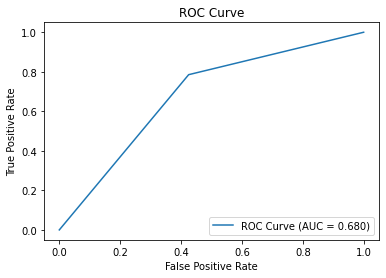

In [439]:
# Υπολογισμός των ποσοστών ψευδώς θετικών και αληθώς θετικών.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)

# Plot της καμπύλης ROC
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.3f)' % lr_roc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [440]:
from sklearn.metrics import f1_score

lr_f1 = f1_score(y_test, y_pred_lr)
print(f'F1 Score: {lr_f1:.3f}')

F1 Score: 0.742


### **KNN Algorithm**

**Train Accuracy Score**: 0.727

**Test Accuracy Score**: 0.698

**F1 Score**: 0.754

In [363]:
knn_mod = KNeighborsClassifier(n_neighbors = 31, metric = 'minkowski', p = 2)
knn_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου για το train set
y_trainpred_knn = knn_mod.predict(X_train)
knn_accuracy_train = accuracy_score(y_train, y_trainpred_knn)

# Πρόβλεψη μοντέλου για το test set
y_pred_knn = knn_mod.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

print(f'Train Accuracy: {knn_accuracy_train:.3f} \
      \nTest Accuracy: {knn_accuracy:.3f}')

Train Accuracy: 0.727       
Test Accuracy: 0.698


In [131]:
knn_f1 = f1_score(y_test, y_pred_knn)
print(f'F1 Score: {knn_f1:.3f}')

F1 Score: 0.754


### **SVM Algorithm**
**Train Accuracy Score**: 0.886

**Test Accuracy Score**: 0.733

**F1 Score**: 0.775

Σημ: **Αργεί** πάρα πολύ η εκπαίδευση του, σε σχέση με τα υπόλοιπα μοντέλα.

In [365]:
svm_mod = SVC(kernel="rbf", random_state=None, probability=True, cache_size=200, gamma=0.1) 
svm_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου για το train set
y_trainpred_svm = svm_mod.predict(X_train)
svm_accuracy_train = accuracy_score(y_train, y_trainpred_svm)

# Πρόβλεψη μοντέλου για το test set
y_pred_svm = svm_mod.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

print(f'Train Accuracy: {svm_accuracy_train:.3f} \
      \nTest Accuracy: {svm_accuracy:.3f}')

Train Accuracy: 0.886       
Test Accuracy: 0.733


In [366]:
svm_f1 = f1_score(y_test, y_pred_svm)
print(f'F1 Score: {svm_f1:.3f}')

F1 Score: 0.775


### **Decision Tree**
**Train Accuracy Score**: 0.999

**Test Accuracy Score**: 0.674

**F1 Score**: 0.709

In [369]:
dct_mod = DecisionTreeClassifier()
dct_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου για το train set
y_trainpred_dct = dct_mod.predict(X_train)
dct_accuracy_train = accuracy_score(y_train, y_trainpred_dct)

# Πρόβλεψη μοντέλου για το test set
y_pred_dct = dct_mod.predict(X_test)
dct_accuracy = accuracy_score(y_test, y_pred_dct)

print(f'Train Accuracy: {dct_accuracy_train:.3f} \
      \nTest Accuracy: {dct_accuracy:.3f}')

Train Accuracy: 0.999       
Test Accuracy: 0.678


In [370]:
dct_f1 = f1_score(y_test, y_pred_dct)
print(f'F1 Score: {dct_f1:.3f}')

F1 Score: 0.712


### **Random Forest**
**Train Accuracy Score**: 0.999

**Test Accuracy Score**: 0.755

**F1 Score**: 0.791

Το **καλύτερο** μας μοντέλο, με αρκετά μεγάλη διαφορά σε **accuracy**, καθώς και **πολύ γρήγορο** στην **εκπαίδευση** του.

In [371]:
rnf_mod =  RandomForestClassifier()
rnf_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου για το train set
y_trainpred_rnf = rnf_mod.predict(X_train)
rnf_accuracy_train = accuracy_score(y_train, y_trainpred_rnf)

# Πρόβλεψη μοντέλου για το test set
y_pred_rnf = rnf_mod.predict(X_test)
rnf_accuracy = accuracy_score(y_test, y_pred_rnf)

print(f'Train Accuracy: {rnf_accuracy_train:.3f} \
      \nTest Accuracy: {rnf_accuracy:.3f}')

Train Accuracy: 0.999       
Test Accuracy: 0.755


In [377]:
rnf_f1 = f1_score(y_test, y_pred_rnf)
print(f'F1 Score: {rnf_f1:.3f}')

F1 Score: 0.791


### **Naive Bayes**
**Train Accuracy Score**: 0.636

**Test Accuracy Score**: 0.638

**F1 Score**: 0.671

In [378]:
bayes_mod =  GaussianNB()
bayes_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου για το train set
y_trainpred_bayes = bayes_mod.predict(X_train)
bayes_accuracy_train = accuracy_score(y_train, y_trainpred_bayes)

# Πρόβλεψη μοντέλου για το test set
y_pred_bayes = bayes_mod.predict(X_test)
bayes_accuracy = accuracy_score(y_test, y_pred_bayes)

print(f'Train Accuracy: {bayes_accuracy_train:.3f} \
      \nTest Accuracy: {bayes_accuracy:.3f}')

Train Accuracy: 0.636       
Test Accuracy: 0.638


In [379]:
bayes_f1 = f1_score(y_test, y_pred_bayes)
print(f'F1 Score: {bayes_f1:.3f}')

F1 Score: 0.671


### **Neural Network**
**Train accuracy**: 0.882
    
**Test accuracy**: 0.734

In [380]:
def NeuralN(X_train, X_test, y_train, y_test):

  model = keras.Sequential([
      layers.Input(shape=(X_train.shape[1],), name='input'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(3, activation='softmax', name='output')      
  ])

  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
  )
  model.summary()
  history = model.fit(X_train, y_train, epochs=50, batch_size = 64)
  train_accuracy = model.evaluate(X_train, y_train)
  test_accuracy = model.evaluate(X_test, y_test)

  y_test_c = tf.keras.utils.to_categorical(y_test)

  y_pred = model.predict(X_test)
  pred_idx = np.argmax(y_pred, axis=1)
  true_idx = np.argmax(y_test_c, axis=1)
  tf_confmatrix = tf.math.confusion_matrix(true_idx, pred_idx)

  return train_accuracy, test_accuracy, tf_confmatrix

In [381]:
nn_train_accuracy, nn_test_accuracy, tf_confmatrix = \
              NeuralN(X_train, X_test, y_train, y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               10800     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 output (Dense)              (None, 3)                 303       
                                                                 
Total params: 41,403
Trainable params: 41,403
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
138/138 [==============================

In [382]:
print(f'Train accuracy: {nn_train_accuracy[1]:.3f}\
    \nTest accuracy: {nn_test_accuracy[1]:.3f}')

Train accuracy: 0.882    
Test accuracy: 0.734


In [383]:
tf_confmatrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1020,  634],
       [ 374, 1755]], dtype=int32)>

### **Πίνακας με όλα τα accuracies**

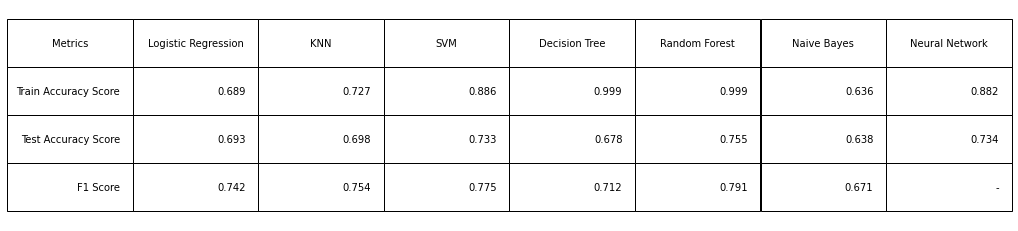

In [388]:
labels = ['Metrics', 'Logistic Regression', 'KNN', 'SVM', 'Decision Tree',
          'Random Forest', 'Naive Bayes', 'Neural Network']

data = [['Train Accuracy Score', lr_accuracy_train, knn_accuracy_train, svm_accuracy_train,\
         dct_accuracy_train, rnf_accuracy_train, bayes_accuracy_train, nn_train_accuracy[1]],
        [ 'Test Accuracy Score', lr_accuracy, knn_accuracy, svm_accuracy, dct_accuracy, \
                                          rnf_accuracy, bayes_accuracy, nn_test_accuracy[1]],
        [ 'F1 Score', lr_f1, knn_f1, svm_f1, dct_f1, rnf_f1, bayes_f1, '-']]

for i in range(len(data)):
    for j in range(len(data[i])):
        if isinstance(data[i][j], float):
            data[i][j] = round(data[i][j], 3)

data = np.array(data)

# data = np.round(data, 3)
fig, ax = plt.subplots()
table = ax.table(cellText=data, colLabels=labels, loc='center')
table.set_fontsize(20)
table.scale(3,4)
ax.axis('off')
ax.grid(False)

plt.show()

## **2. Με χρήση υποσυνόλου 5 γνωρισμάτων**.
Σε αυτό το μέρος θα πάρουμε το dataframe που είχαμε κρατήσει στην μεταβλητή **sec_df**, το οποίο είναι καθαρό από ελλιπείς εγγραφές, και γνωρίσματα που δεν προσφέρουν πληροφορία, και θα προσπαθήσουμε να επιλέξουμε **5 γνωρίσματα** από αυτό, πάνω στα οποία θα εκπαιδεύσουμε τον καλύτερο μας μοντέλο, δηλαδή το **Random Forest**, και θα σχολιάσουμε τα αποτελέσματα.

Δύο τρόποι που διαλέξαμε για την επιλογή των 5 γνωρισμάτων είναι ο VarianceThreshold και ο SelectKBest, οι οποίοι για να δουλέψουν χρειάζονται ποσοτικά δεδομένα, οπότε θα χρησιμοποιήσουμε το αντίγραφο από το one-hot encoded dataframe, που είχαμε πάρει παραπάνω.

### **SelectKBest**
Σε αυτή τη μέθοδο επιλέγουμε τον **αριθμό των γνωρισμάτων** που θέλουμε να επιλεχθούν, βάζοντας το **k=5**.

In [498]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_1 = sec_df.drop(['Y'], axis=1)
y = sec_df['Y']

# Στο k βάζουμε τον αριθμό των γνωρισμάτων που θέλουμε να επιλεχθούν.
selector = SelectKBest(f_classif, k=5)
X_new_1 = selector.fit_transform(X_1, y)

# Παίρνουμε τους δείκτες των γνωρισμάτων που επιλέχθηκαν.
selected_feature_indices = selector.get_support(indices=True)

selected_feature_indices

array([ 6, 20, 21, 24, 26])

In [500]:
new_sec_df = sec_df.iloc[:, selected_feature_indices]
new_sec_df.head()

,destination_Home,time_7AM,coupon_Bar,coupon_Restaurant(20-50),expiration_1d
0,0,0,0,0,1
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [488]:
sec_X_train, sec_X_test, sec_y_train, sec_y_test = \
train_test_split(new_sec_df, y, train_size=0.7, random_state=42)

In [491]:
sec_rnf_mod =  RandomForestClassifier()
sec_rnf_mod.fit(sec_X_train, sec_y_train)

# Πρόβλεψη μοντέλου στο train set
sec_y_predtrain_rnf = sec_rnf_mod.predict(sec_X_train)
sec_rnf_accuracy_train = accuracy_score(sec_y_train, sec_y_predtrain_rnf)

# Πρόβλεψη μοντέλου στο test set
sec_y_pred_rnf = sec_rnf_mod.predict(sec_X_test)
sec_rnf_accuracy = accuracy_score(sec_y_test, sec_y_pred_rnf)

print(f'Train accuracy: {sec_rnf_accuracy_train:.3f}\
        \nTest accuracy: {sec_rnf_accuracy:.3f}')

Train accuracy: 0.641        
Test accuracy: 0.640


### **VarianceThreshold**
Σε αυτή τη μέθοδο δεν επιλέγουμε εμείς τον αριθμό των γνωρισμάτων αλλά αυτή διώχνει τα γνωρίσματα των οποίων η απόκλιση είναι μεγαλύτερη από το **threshold** που έχουμε ορίσει. Παρατηρήσαμε ότι με **threshold=0.247** μένουν 5 γνωρίσματα, οπότε επιλέγουμε αυτό. 

In [492]:
from sklearn.feature_selection import VarianceThreshold

X2 = sec_df.drop(['Y'], axis=1)

# Βάζουμε το threshold στο 0.247, για να μείνουν τα 5 γνωρίσματα.
selector = VarianceThreshold(threshold=0.247)
X_new2 = selector.fit_transform(X2)

# Παίρνουμε τους δείκτες των γνωρισμάτων που επιλέχθηκαν.
selected_feature_indices2 = selector.get_support(indices=True)

selected_feature_indices2

array([  0,   6,  27,  28, 105])

In [493]:
new_sec_df2 = sec_df.iloc[:, selected_feature_indices2]
new_sec_df2.head()

,temperature,destination_Home,expiration_2h,gender_Female,Restaurant20To50_gt8
0,55,0,0,1,0
1,80,0,1,1,0
2,80,0,1,1,0
3,80,0,1,1,0
4,80,0,0,1,0


In [494]:
sec_X_train2, sec_X_test2, sec_y_train2, sec_y_test2 = \
train_test_split(new_sec_df2, y, train_size=0.7, random_state=42)

In [495]:
sec_rnf_mod2 =  RandomForestClassifier()
sec_rnf_mod2.fit(sec_X_train2, sec_y_train2)

# Πρόβλεψη μοντέλου στο train set
sec_y_predtrain_rnf2 = sec_rnf_mod2.predict(sec_X_train2)
sec_rnf_accuracy_train2 = accuracy_score(sec_y_train2, sec_y_predtrain_rnf2)

# Πρόβλεψη μοντέλου στο test set
sec_y_pred_rnf2 = sec_rnf_mod2.predict(sec_X_test2)
sec_rnf_accuracy2 = accuracy_score(sec_y_test2, sec_y_pred_rnf2)

print(f'Train accuracy: {sec_rnf_accuracy_train2:.3f}\
        \nTest accuracy: {sec_rnf_accuracy2:.3f}')

Train accuracy: 0.604        
Test accuracy: 0.614


# **Γ) Clustering / Συσταδοποίηση**
Στο **τρίτο και τελευταίο μέρος** θα αναπτυχθούν μοντέλα **συσταδοποίησης** και θα **εκπαιδευτούν** στο ήδη **καθαρισμένο** (από το **A μέρος**) **dataset** μας.

In [501]:
cluster_df.head()

,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,...,RestaurantLessThan20_1~3,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_1~3,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,55,1,0,0,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,0
1,80,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
2,80,1,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,80,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,80,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


In [502]:
cluster_df.shape

(12610, 108)

In [503]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_cluster_df = scaler.fit_transform(cluster_df)

## **PCA**
Επειδή έχουμε πάρα πολλά γνωρίσματα (**110 γνωρίσματα = 110 διαστάσεις**) και δεν μπορούμε να τα κάνουμε **plot** στον δισδιάστατο χώρο, θα χρησιμοποιήσουμε την τεχνική **επιλογής χαρακτηριστικών PCA** (**Ανάλυση κύριων συνιστωσών**) για να **μειώσουμε τη διαστατικότητα** των δεδομένων. Η **PCA** είναι μία τεχνική **χωρίς επίβλεψη** και δεν θα λάβει υπόψη τις ετικέτες των δεδομένων ("**Y**"), αλλά μπορεί να χρησιμοποιηθεί για να κάνει τη διαδικασία της συσταδοποίησης **πιο αποδοτική από υπολογιστική άποψη**. Να σημειωθέι ότι έχουμε την δυνατότητα να καθορίσουμε τον **αριθμό των συνιστωσών** που θέλουμε να διατηρήσουμε.

Επίσης η τεχνική αυτή συνίσταται με χρήση της **StandardScaler()** μιας και τα αποτελέσματα της είναι **πολύ ευαίσθητα** στην **κλιμάκωση των δεδομένων**. Βέβαια τα γνωρίσματα των δειγμάτων μας, πέραν του **temperature**, παίρνουν **τιμές 0 και 1**, οπότε **δεν θα χρειαστεί** η εφαρμογή του **StandardScaler()**.

In [504]:
from sklearn.decomposition import PCA

# Δημιουργία αντικειμένου PCA με το επιθυμητό πλήθος συνιστωσών.
pca = PCA(n_components=2)

# Μετασχηματισμός δεδομένων με χρήση του αντικειμένου PCA.
cluster_df_pca = pca.fit_transform(scaled_cluster_df)


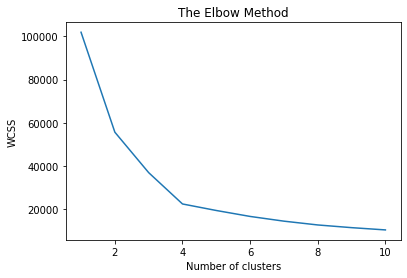

In [505]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(cluster_df_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [517]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(cluster_df_pca)

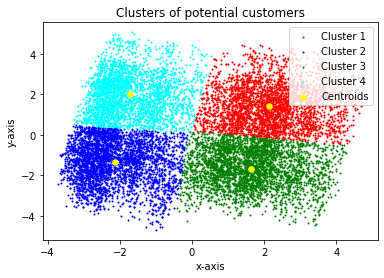

In [518]:
plt.scatter(cluster_df_pca[y_kmeans == 0, 0], cluster_df_pca[y_kmeans == 0, 1], s = 1, c = 'red', label = 'Cluster 1')
plt.scatter(cluster_df_pca[y_kmeans == 1, 0], cluster_df_pca[y_kmeans == 1, 1], s = 1, c = 'blue', label = 'Cluster 2')
plt.scatter(cluster_df_pca[y_kmeans == 2, 0], cluster_df_pca[y_kmeans == 2, 1], s = 1, c = 'green', label = 'Cluster 3')
plt.scatter(cluster_df_pca[y_kmeans == 3, 0], cluster_df_pca[y_kmeans == 3, 1], s = 1, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'yellow', label = 'Centroids')
plt.title('Clusters of potential customers')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()
plt.show()

In [519]:
from sklearn.metrics import silhouette_score

# Predict the cluster labels for each data point
cluster_pred = kmeans.predict(cluster_df_pca)

# Compute the silhouette score
score = silhouette_score(cluster_df_pca, cluster_pred)

# Print the silhouette score
print("Silhouette score: {:.3f}".format(score))


Silhouette score: 0.454
